In [2]:
from typing import List, Dict
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib
from pathlib import Path
import matplotlib.pyplot as plt


sns.set(rc={'figure.figsize':(30,40)})
sns.set(font_scale=6)

In [3]:
# Benchmark Table
LIBRARY_NAME: str = "Compression Scheme"
WITH_LTO: str = "with_lto"
CLIENTS: str = "clients"
MULTITHREADED: str = "multithreaded"
RUN_NAME: str = "benchmark_run_name"
QUERY_NAME: str = "Query Name"
RUNTIME_TO_BASELINE: str = "runtime_to_baseline"
AVG_DURATION: str = "Avg. Runtime (in ms)"
TOTAL_RUNTIME: str = "Total Runtime (in seconds)"
REDUCTION: str = "reduction"
BETTER_THAN_DEFAULT: str = "better_than_default"

# Sizes
SIZE_TO_BASELINE: str = "size_to_baseline"
TABLE_NAME: str = "table_name"
COLUMN_NAME: str = "column_name"
DATA_TYPE: str = "column_data_type"
SIZE_IN_BYTES: str = "size_in_bytes"


In [4]:

def fancy_name(benchmark_name: str) -> str:
    fancy_name: str = benchmark_name.split(".")[-2]\
        .replace("_shuffled", "")\
        .replace("_LTO", "")\
        .replace("tpch_", "")\
        .split("/")[-1]
    removed_numbers = fancy_name[:fancy_name.rindex("_")]
    return removed_numbers

def filter_unneccessary_benchmarks(data: DataFrame) -> DataFrame:
    filtered: DataFrame = data[~data[RUN_NAME].str.match(".*(LZ4|RunLength).*")]
    return filtered

def get_clients(run_name: str) -> int:
    if "shuffled" in run_name:
        clients_number: str = run_name.split(".")[-2].replace("_shuffled", "").split("_")[-1]
        return int(clients_number)
    return 1

def complete_info(data: DataFrame) -> DataFrame:
    new_data: DataFrame = data.copy()
    new_data[LIBRARY_NAME] = [fancy_name(b) for b in new_data[RUN_NAME]]
    new_data[WITH_LTO] = ["LTO" in benchmark_run_name for benchmark_run_name in new_data[RUN_NAME]]
    new_data[CLIENTS] = [get_clients(run_name)
                           for run_name in new_data[RUN_NAME]]
    new_data[MULTITHREADED] = ["shuffled" in benchmark_run_name for benchmark_run_name in new_data[RUN_NAME]]
    return new_data

def complete_with_sizes(data: DataFrame, sizes_folder: Path) -> DataFrame:
    all_sizes: DataFrame = DataFrame()
    for library in data[LIBRARY_NAME].drop_duplicates():
        sizes: DataFrame = load_sizes(sizes_folder / f"sizes_{library}.txt")
        grouped_by_datatype = sizes.groupby(DATA_TYPE)[SIZE_IN_BYTES].sum()
        grouped_by_datatype = grouped_by_datatype.T
        grouped_by_datatype[LIBRARY_NAME] = library
        all_sizes = all_sizes.append(grouped_by_datatype)
    completed_with_size = data.merge(all_sizes, on=LIBRARY_NAME, how="left")
    return completed_with_size

def rename(data: DataFrame) -> DataFrame:
    renamed: DataFrame = data.rename(columns={"benchmark_run_name": RUN_NAME, "total_runtime": TOTAL_RUNTIME,
                                              "query_name": QUERY_NAME, "avg_duration": AVG_DURATION})
    return renamed

def get_high_level(data_folder: Path, sizes_folder: Path) -> DataFrame:
    high_level: DataFrame = pd.read_csv(f"{data_folder}/benchmarks_parsed_high_level.csv")
    high_level = rename(high_level)
    high_level = high_level.sort_values(RUN_NAME)
    high_level = filter_unneccessary_benchmarks(high_level)
    high_level = complete_info(high_level)
    high_level = complete_with_sizes(high_level, sizes_folder)
    high_level[TOTAL_RUNTIME] = [runtime / 1e9 for runtime in high_level[TOTAL_RUNTIME]]
    return high_level

def get_low_level(data_folder: Path) -> DataFrame:
    low_level: DataFrame = pd.read_csv(f"{data_folder}/benchmarks_parsed_low_level.csv")
    low_level = rename(low_level)
    low_level = low_level.sort_values(QUERY_NAME)
    low_level = filter_unneccessary_benchmarks(low_level)
    low_level = complete_info(low_level)
    low_level[AVG_DURATION] = [duration / 1e6 for duration in low_level[AVG_DURATION]]
    return low_level

def load_sizes(sizes_file: Path) -> DataFrame:
    all_entries: List[List[str]] = []
    av_dict_entries: List[List[int]] = []
    column_names: List[str] = []
    types: List[str] = []
    with sizes_file.open() as file:
        table_starts: bool = False
        for line in file:
            if len(column_names) != 0 and table_starts and not '|' in line:
                break
            if not '|' in line:
                continue
            if len(column_names) == 0:
                column_names = [entry.replace(" ", "")
                                for entry in line.split("|") if entry != "" and entry != "\n"]
                continue
            if len(types) == 0:
                types =  [entry.replace(" ", "")
                          for entry in line.split("|") if entry != "" and entry != "\n"]
                continue
            if "<ValueS>" in line:
                table_starts = True
                continue
            if not table_starts:
                continue
            new_entry: List[str] = [entry.replace(" ", "")
                                    for entry in line.split("|") if entry != "" and entry != "\n"]
            all_entries.append(new_entry)
    as_type: Dict[str, str] = {column_names[i]:types[i] for i in range(0, len(column_names))}
    df = DataFrame(data=all_entries, columns=column_names).astype(as_type)
    return df

single_threaded_folder = Path("../data/segmentencoding_singlethreaded/")
multi_threaded_folder: Path = Path("../data/segmentencoding_multithreaded/")
sizes_folder: Path = Path("../data/segmentencoding_singlethreaded/")
high_level_mult: DataFrame = get_high_level(multi_threaded_folder, sizes_folder)
low_level_mult: DataFrame = get_low_level(multi_threaded_folder)
high_level_single: DataFrame = get_high_level(single_threaded_folder, sizes_folder)
low_level_single: DataFrame = get_low_level(single_threaded_folder)
high_level_single

,benchmark_run_name,Total Runtime (in seconds),avg_throughput,Compression Scheme,with_lto,clients,multithreaded,float,int,string
0,./tpch_Dictionary_singlethreaded.json,38.747185,1.537464,Dictionary,False,1,False,676386560.0,1.372782e+09,7.950671e+09
1,./tpch_FrameOfReference_singlethreaded.json,35.447879,1.673023,FrameOfReference,False,1,False,676386560.0,9.912806e+08,7.950671e+09
2,./tpch_SIMDCAI_singlethreaded.json,36.831127,1.531125,SIMDCAI,False,1,False,676386560.0,6.464946e+08,7.950671e+09
3,./tpch_TurboPFOR_bitpacking_singlethreaded.json,35.077938,1.606486,TurboPFOR_bitpacking,False,1,False,676386560.0,6.557167e+08,7.950671e+09
4,./tpch_TurboPFOR_singlethreaded.json,37.203742,1.531067,TurboPFOR,False,1,False,676386560.0,6.514422e+08,7.950671e+09
5,./tpch_Unencoded_singlethreaded.json,33.565790,1.883015,Unencoded,False,1,False,676386560.0,1.266756e+09,7.950671e+09
6,./tpch_fastpfor_singlethreaded.json,2833.905662,0.073615,fastpfor,False,1,False,676386560.0,6.638252e+08,7.950671e+09


## Runtime

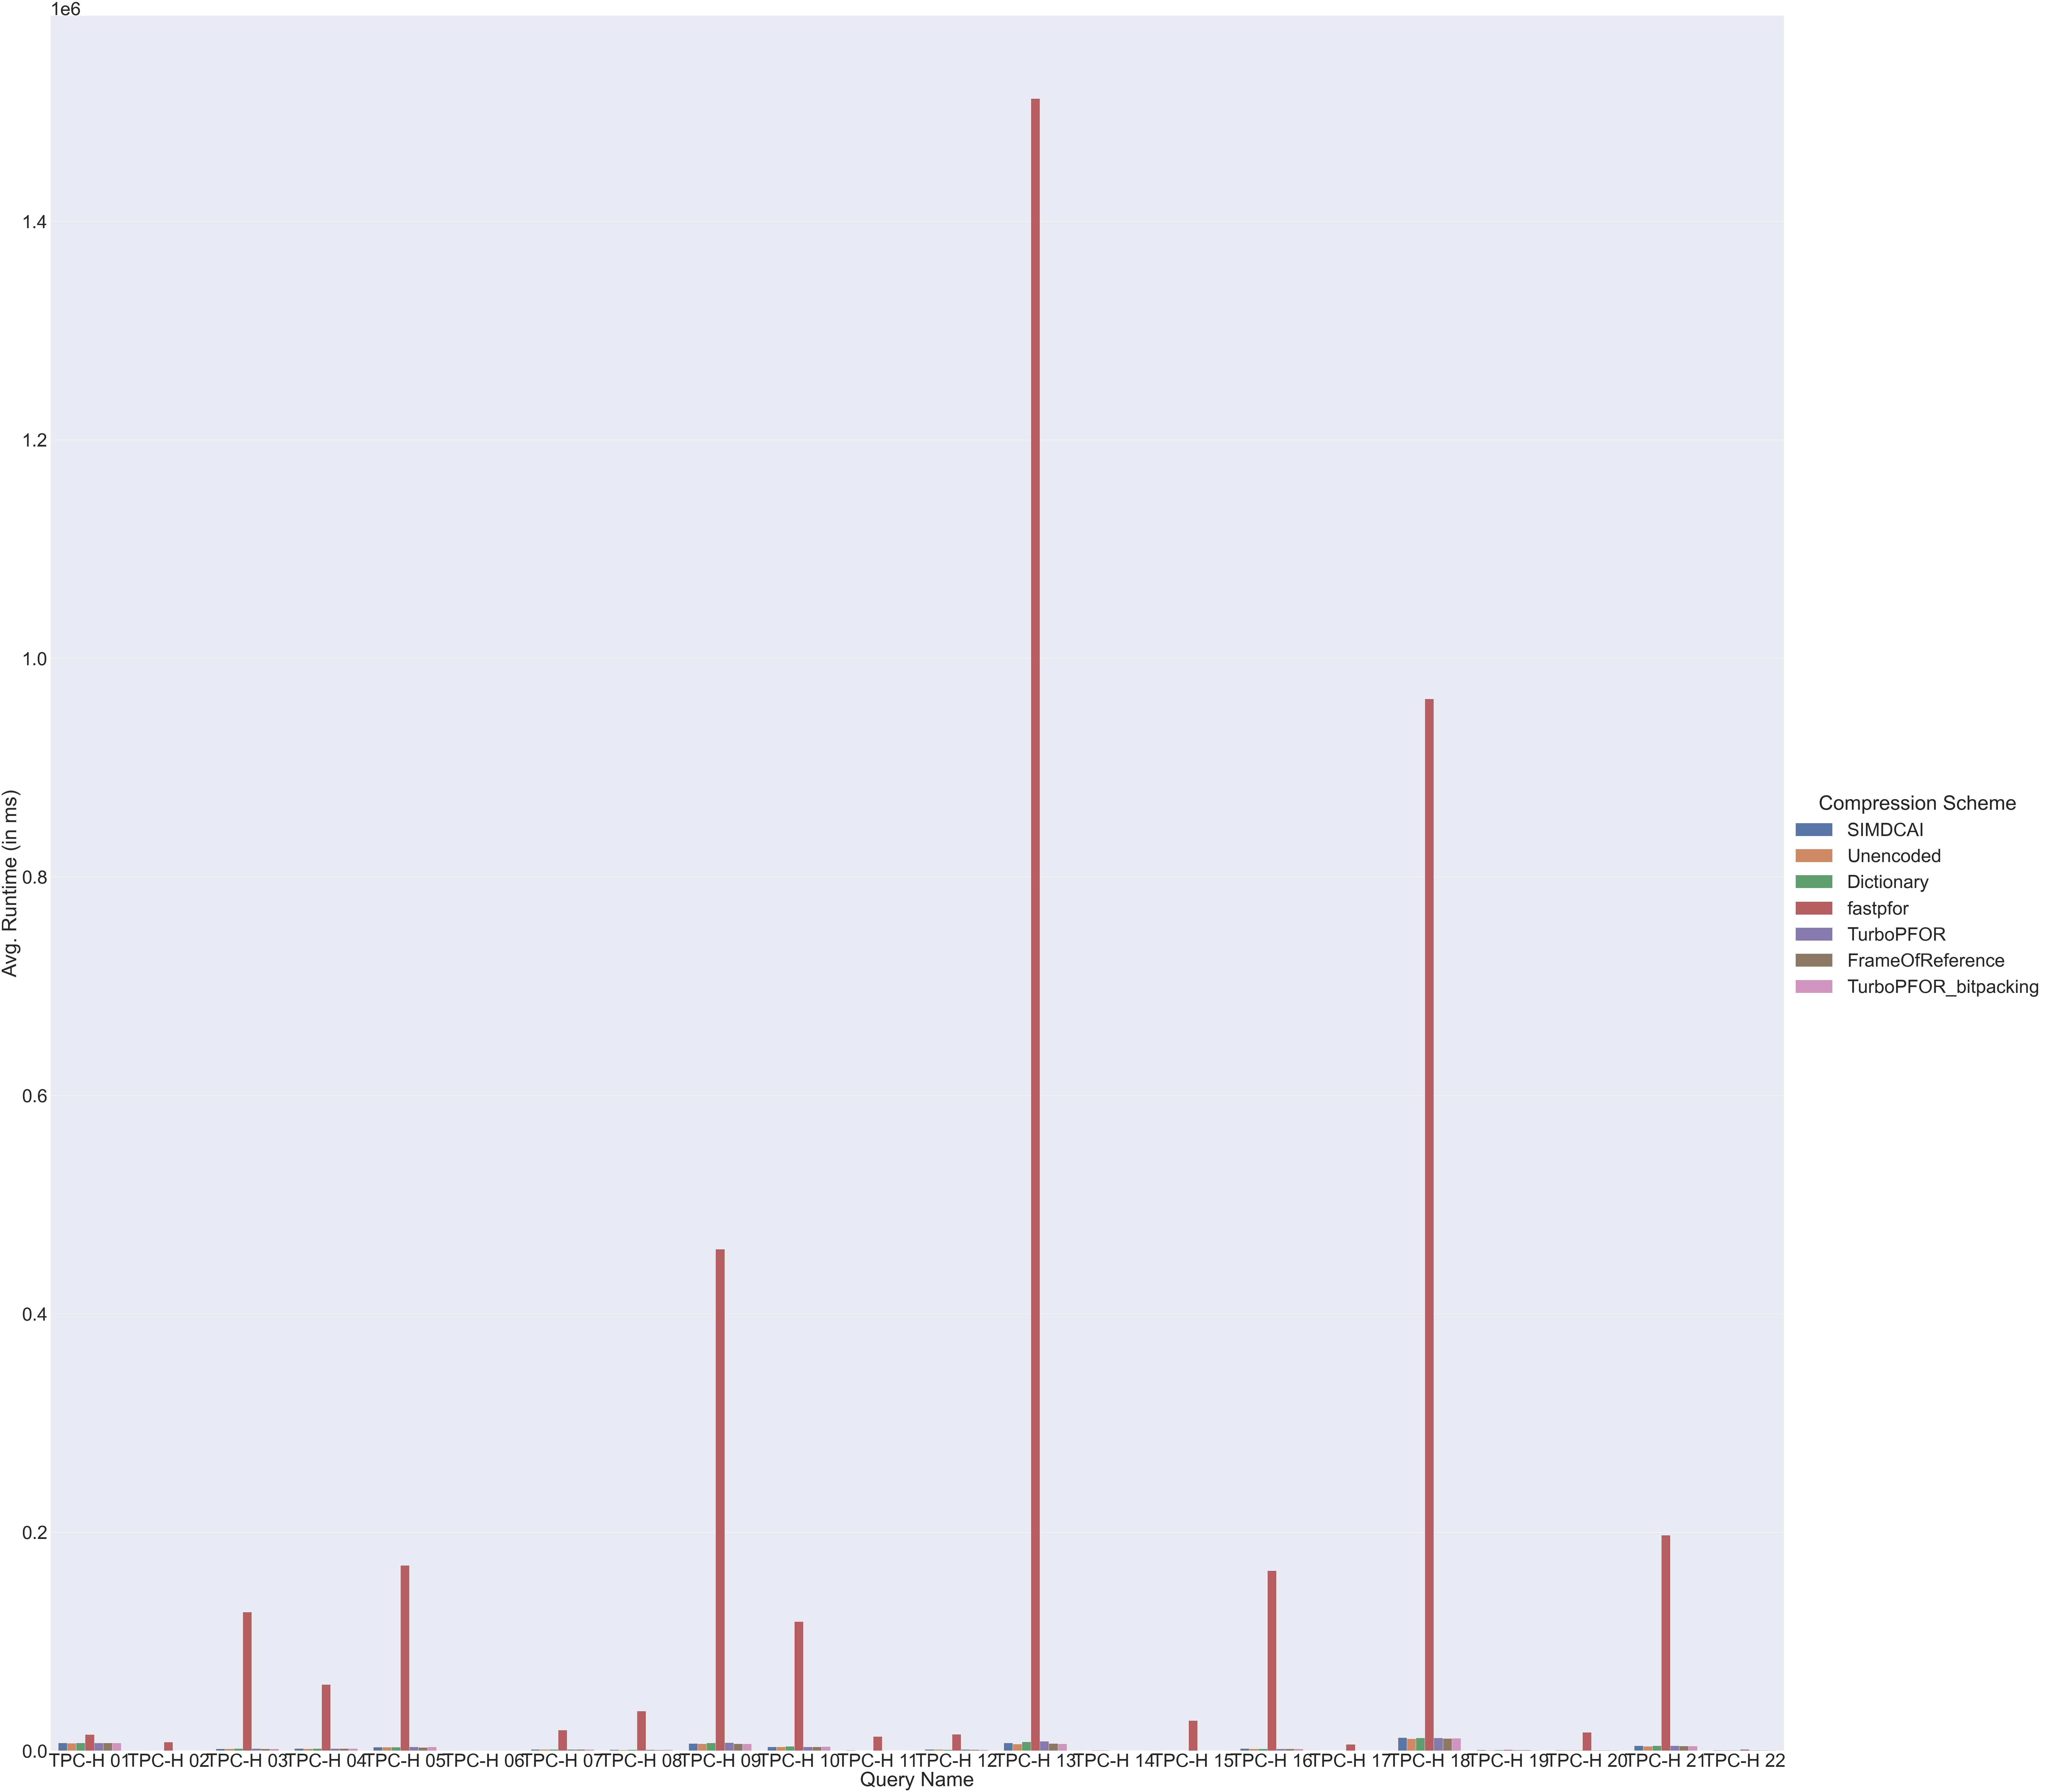

In [5]:
only_28_clients: DataFrame = low_level_mult[low_level_mult[CLIENTS] == 28]
sns.catplot(data=only_28_clients, kind="bar", x=QUERY_NAME, y=AVG_DURATION, hue=LIBRARY_NAME, height=90)

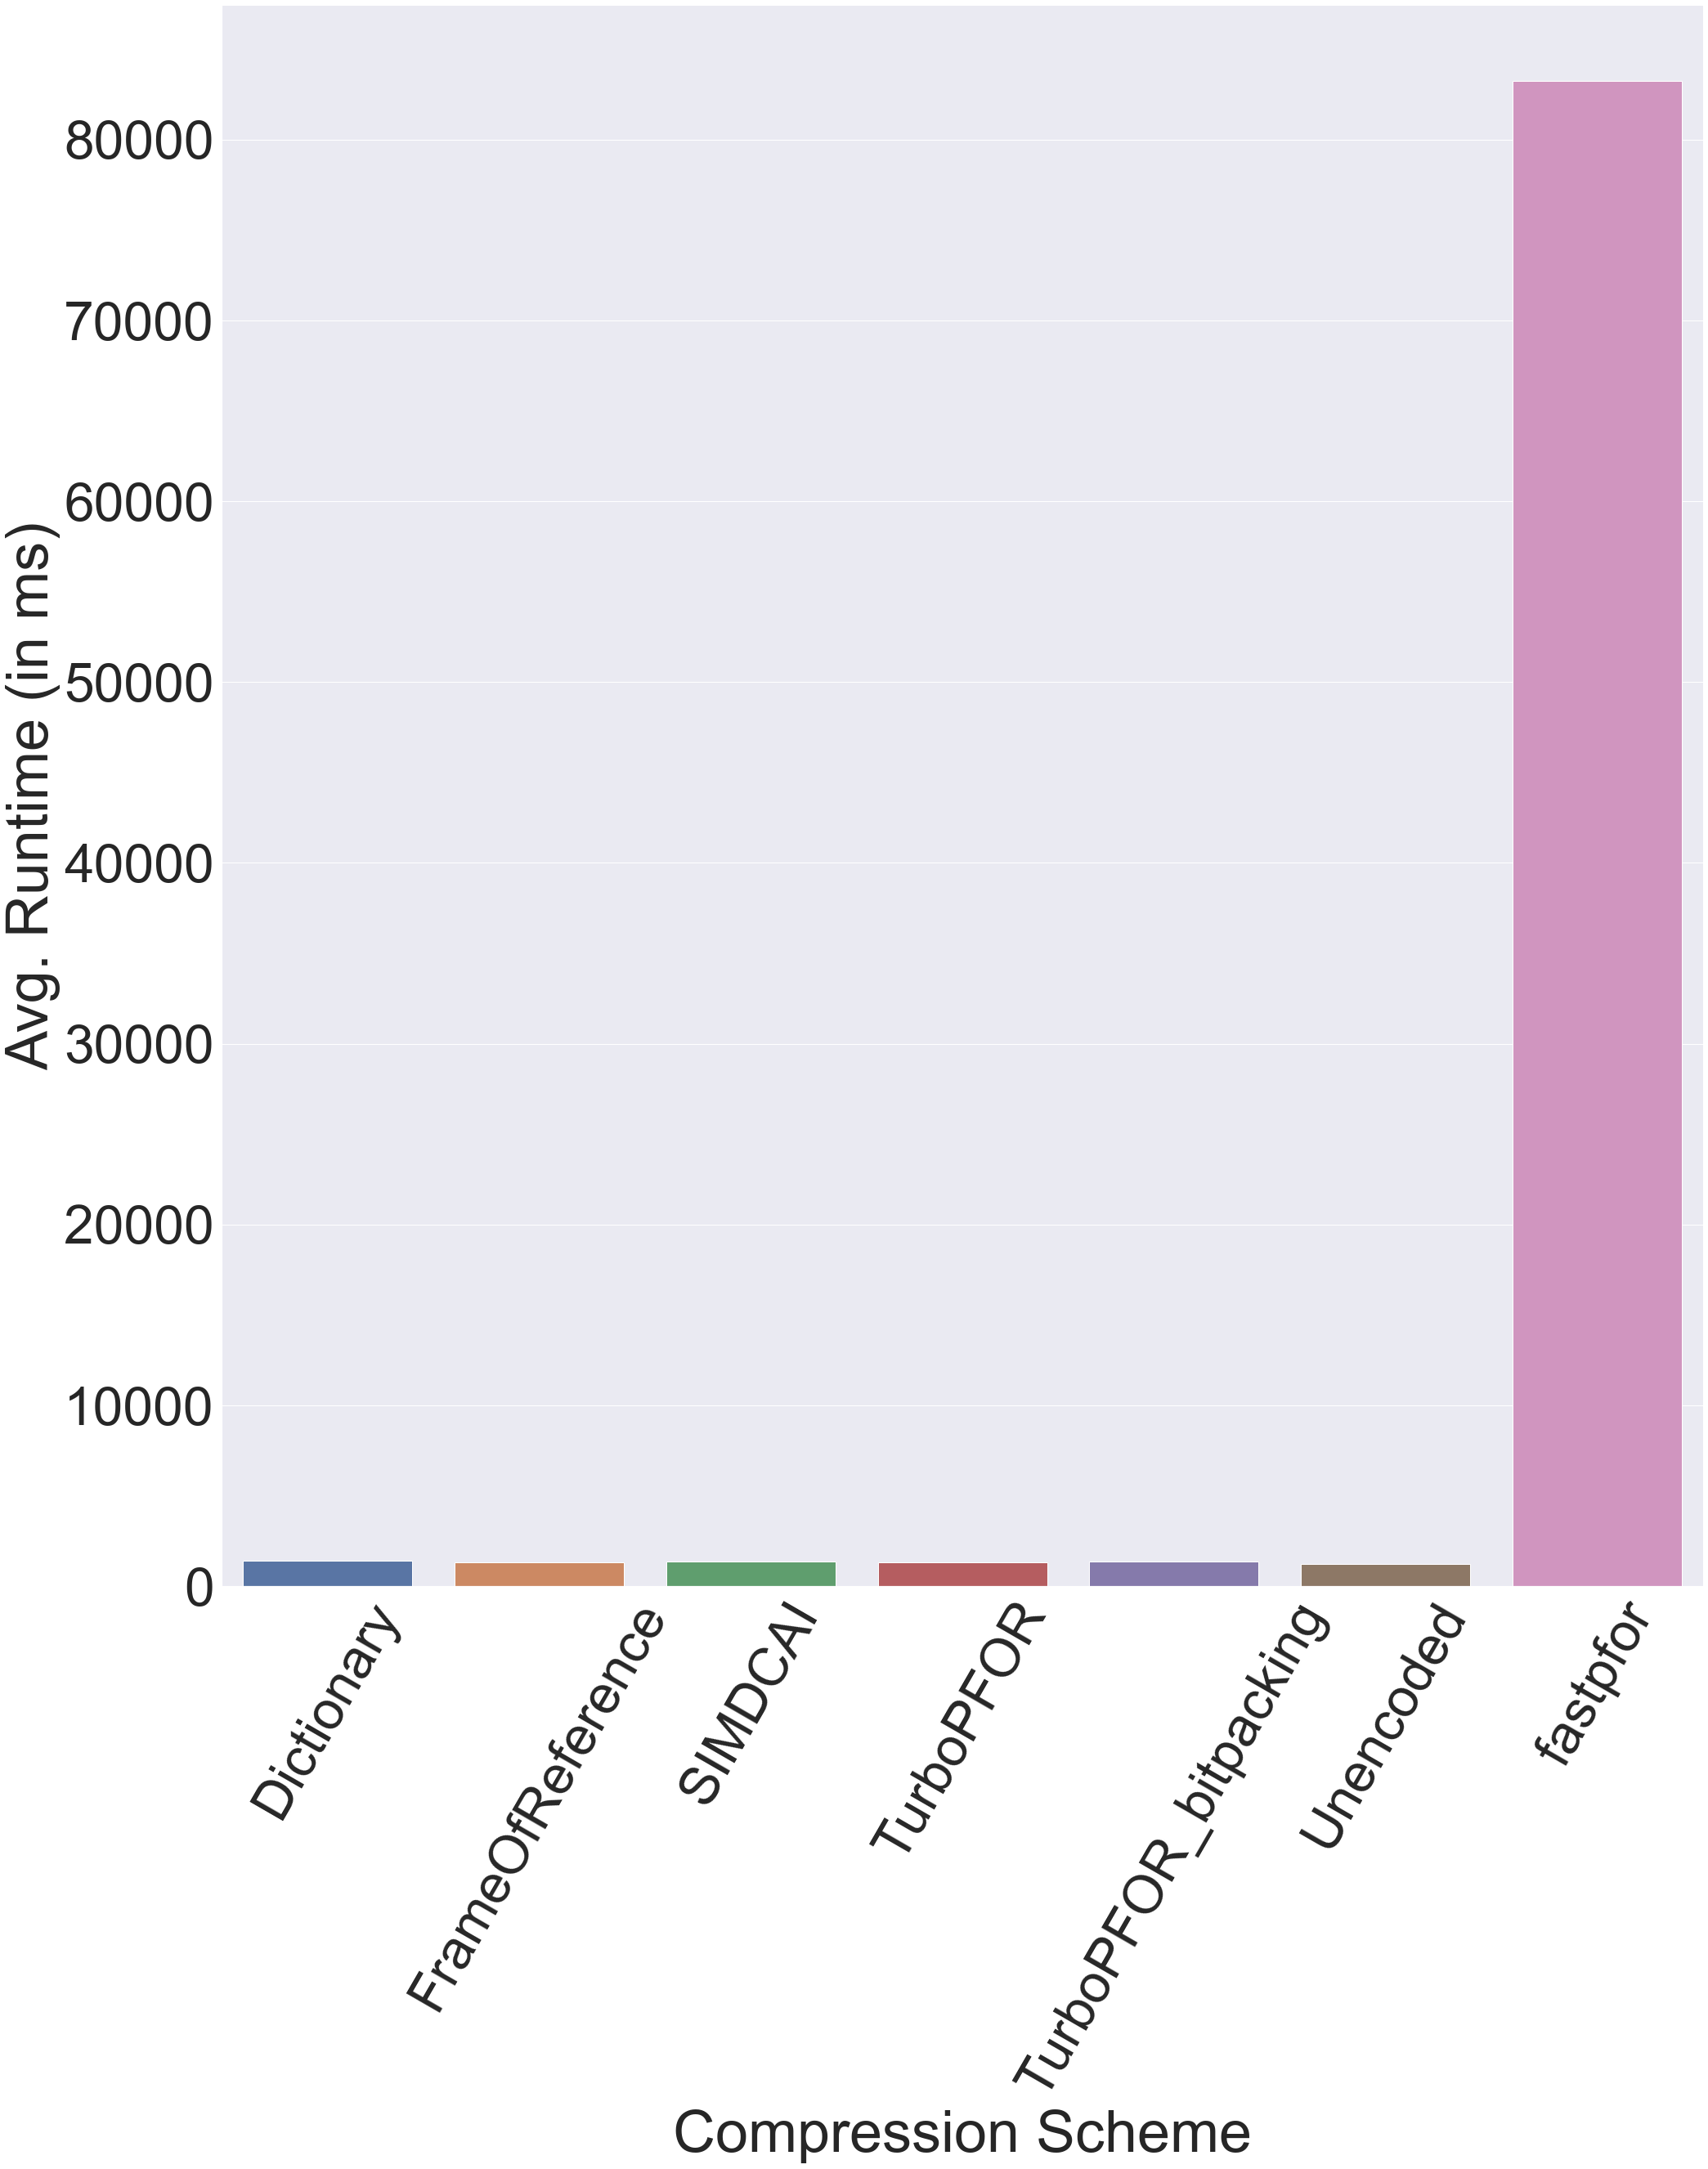

In [6]:
hue_order: List[str] = sorted(low_level_single[LIBRARY_NAME].drop_duplicates())
filtered: DataFrame = low_level_single[low_level_single[QUERY_NAME] == "TPC-H 03"]
sns.catplot(data=filtered, x=LIBRARY_NAME, y=AVG_DURATION, kind="bar", height=30, order=hue_order)
plt.xticks(rotation=60)
plt.savefig("visualizations/tpch03single.png", bbox_inches = "tight")

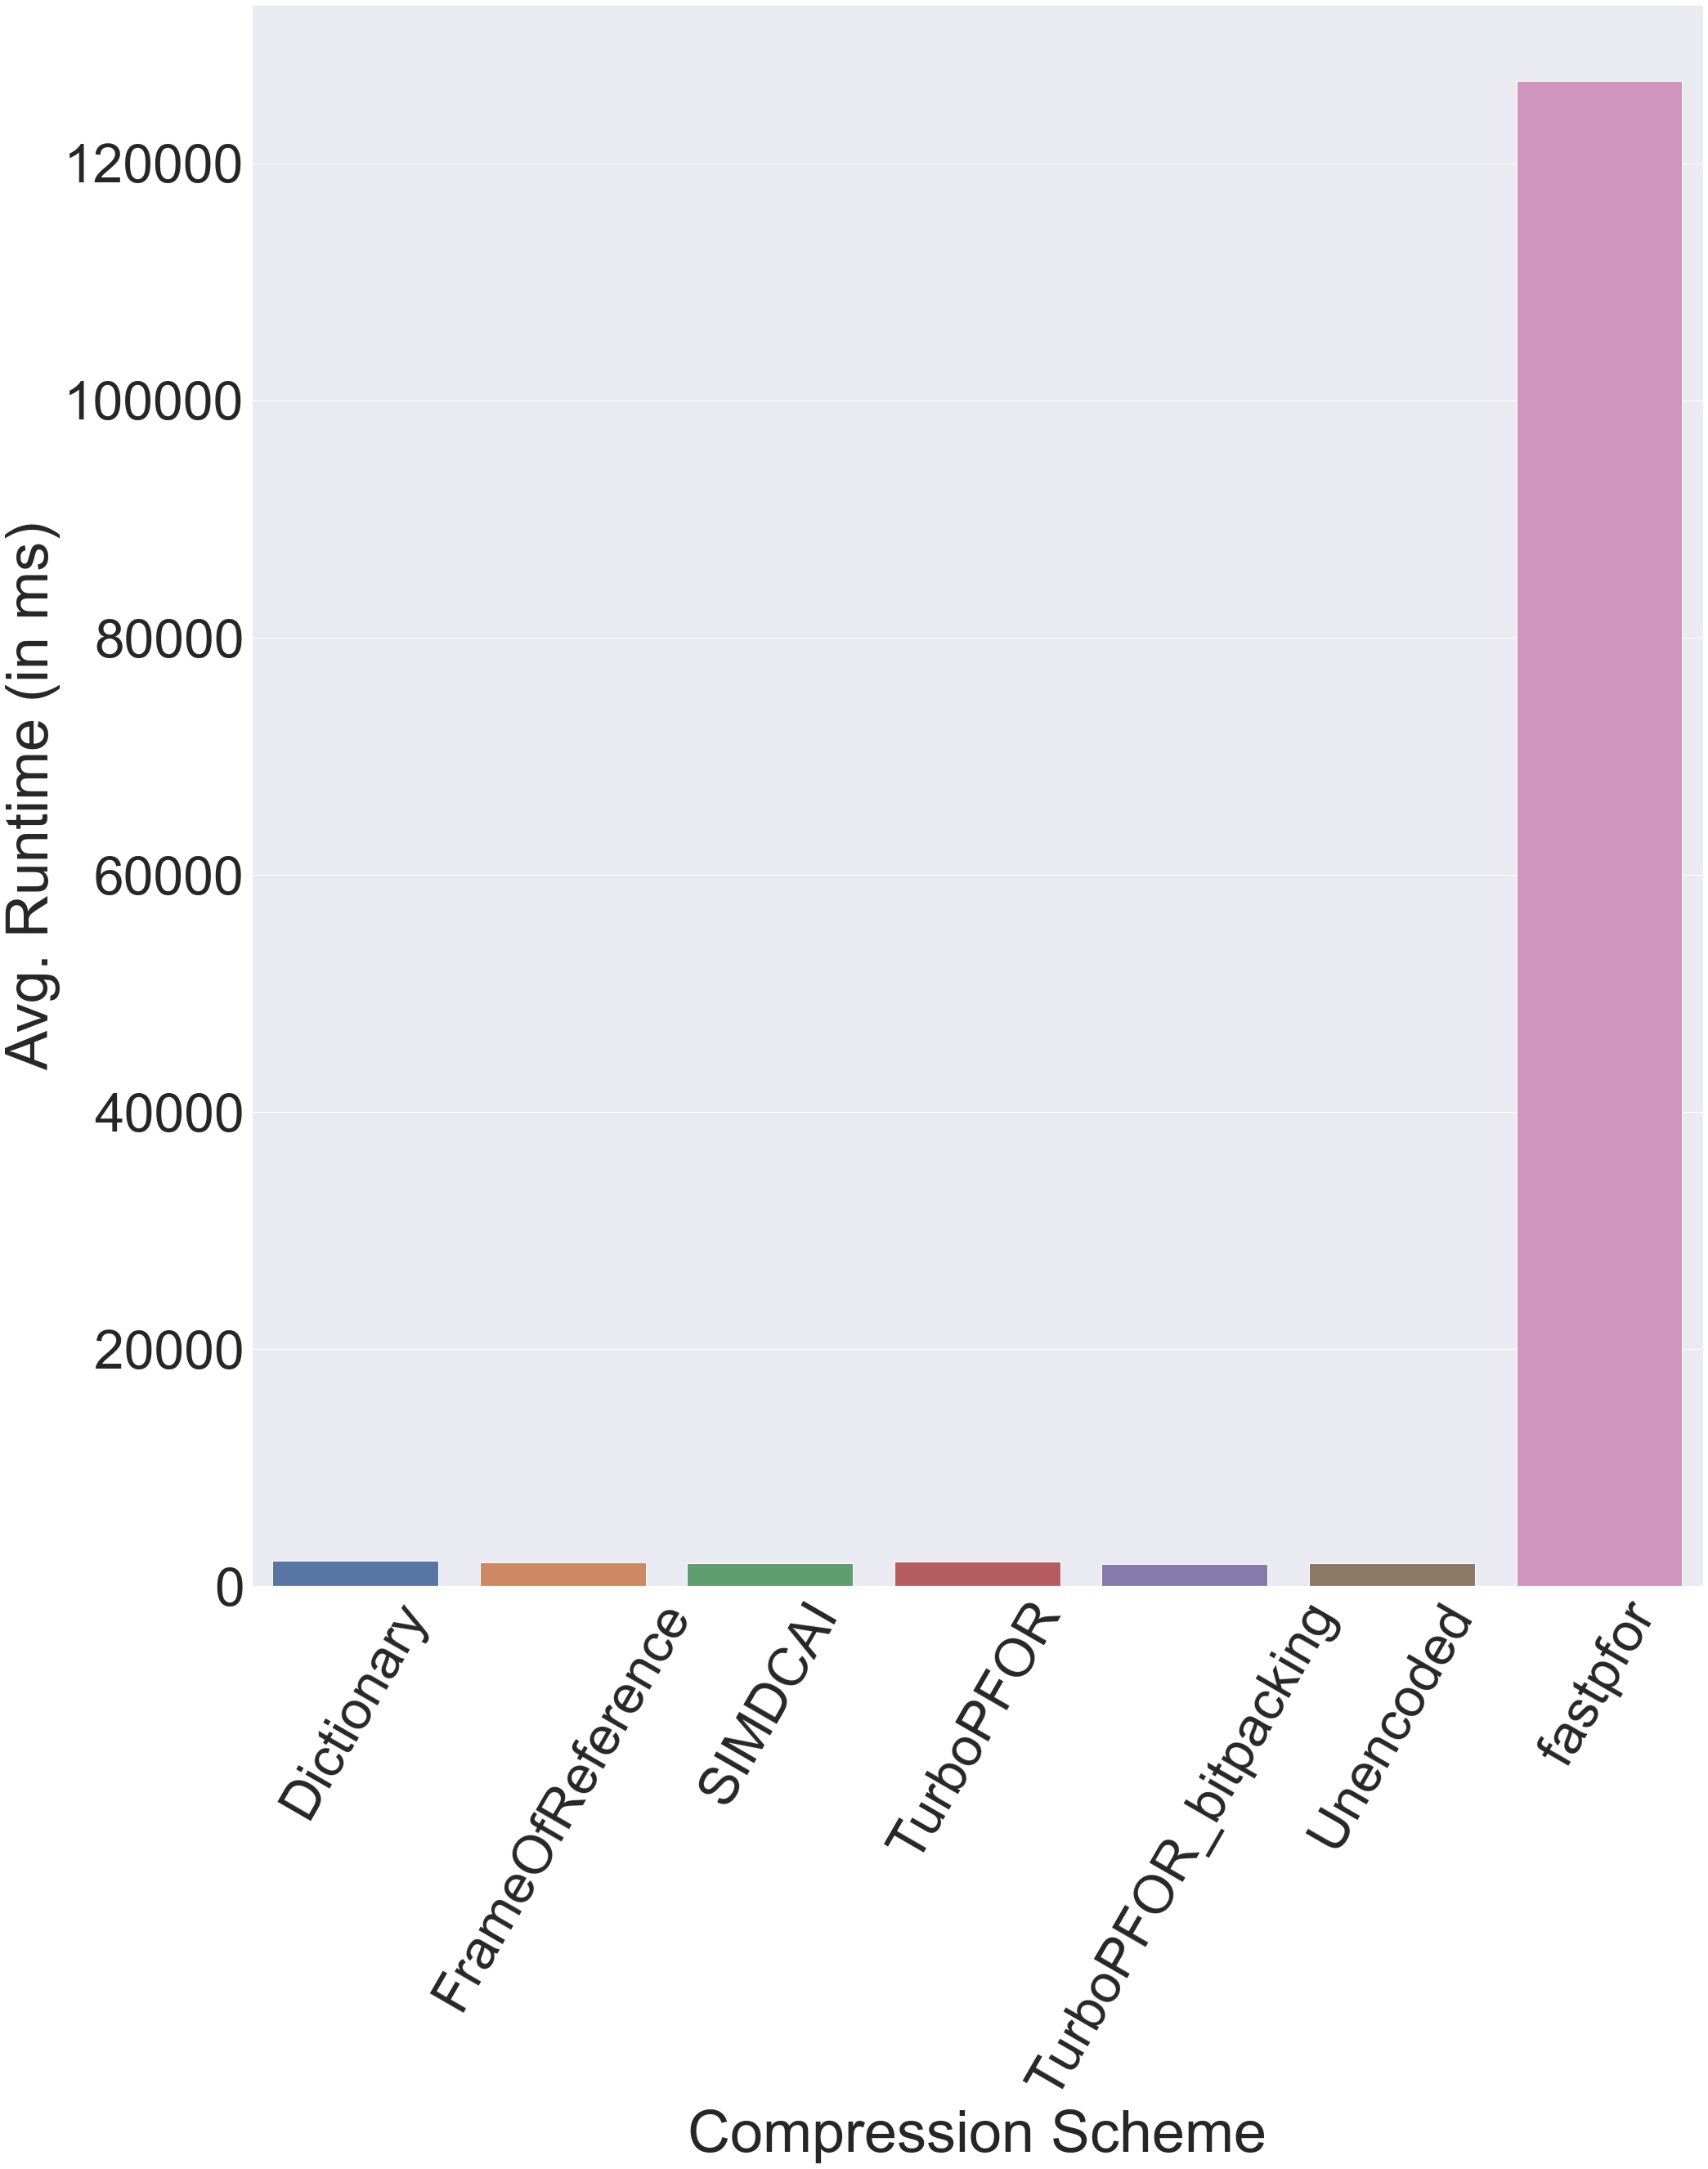

In [7]:
filtered: DataFrame = only_28_clients[only_28_clients[QUERY_NAME] == "TPC-H 03"]
plot = sns.catplot(data=filtered, x=LIBRARY_NAME, y=AVG_DURATION, kind="bar", height=30, order=hue_order)
plt.xticks(rotation=60)
plt.savefig("visualizations/tpch03multi.png", bbox_inches = "tight")

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'FrameOfReference'),
  Text(1, 0, 'Dictionary'),
  Text(2, 0, 'TurboPFOR'),
  Text(3, 0, 'Unencoded'),
  Text(4, 0, 'SIMDCAI'),
  Text(5, 0, 'TurboPFOR_bitpacking'),
  Text(6, 0, 'fastpfor')])

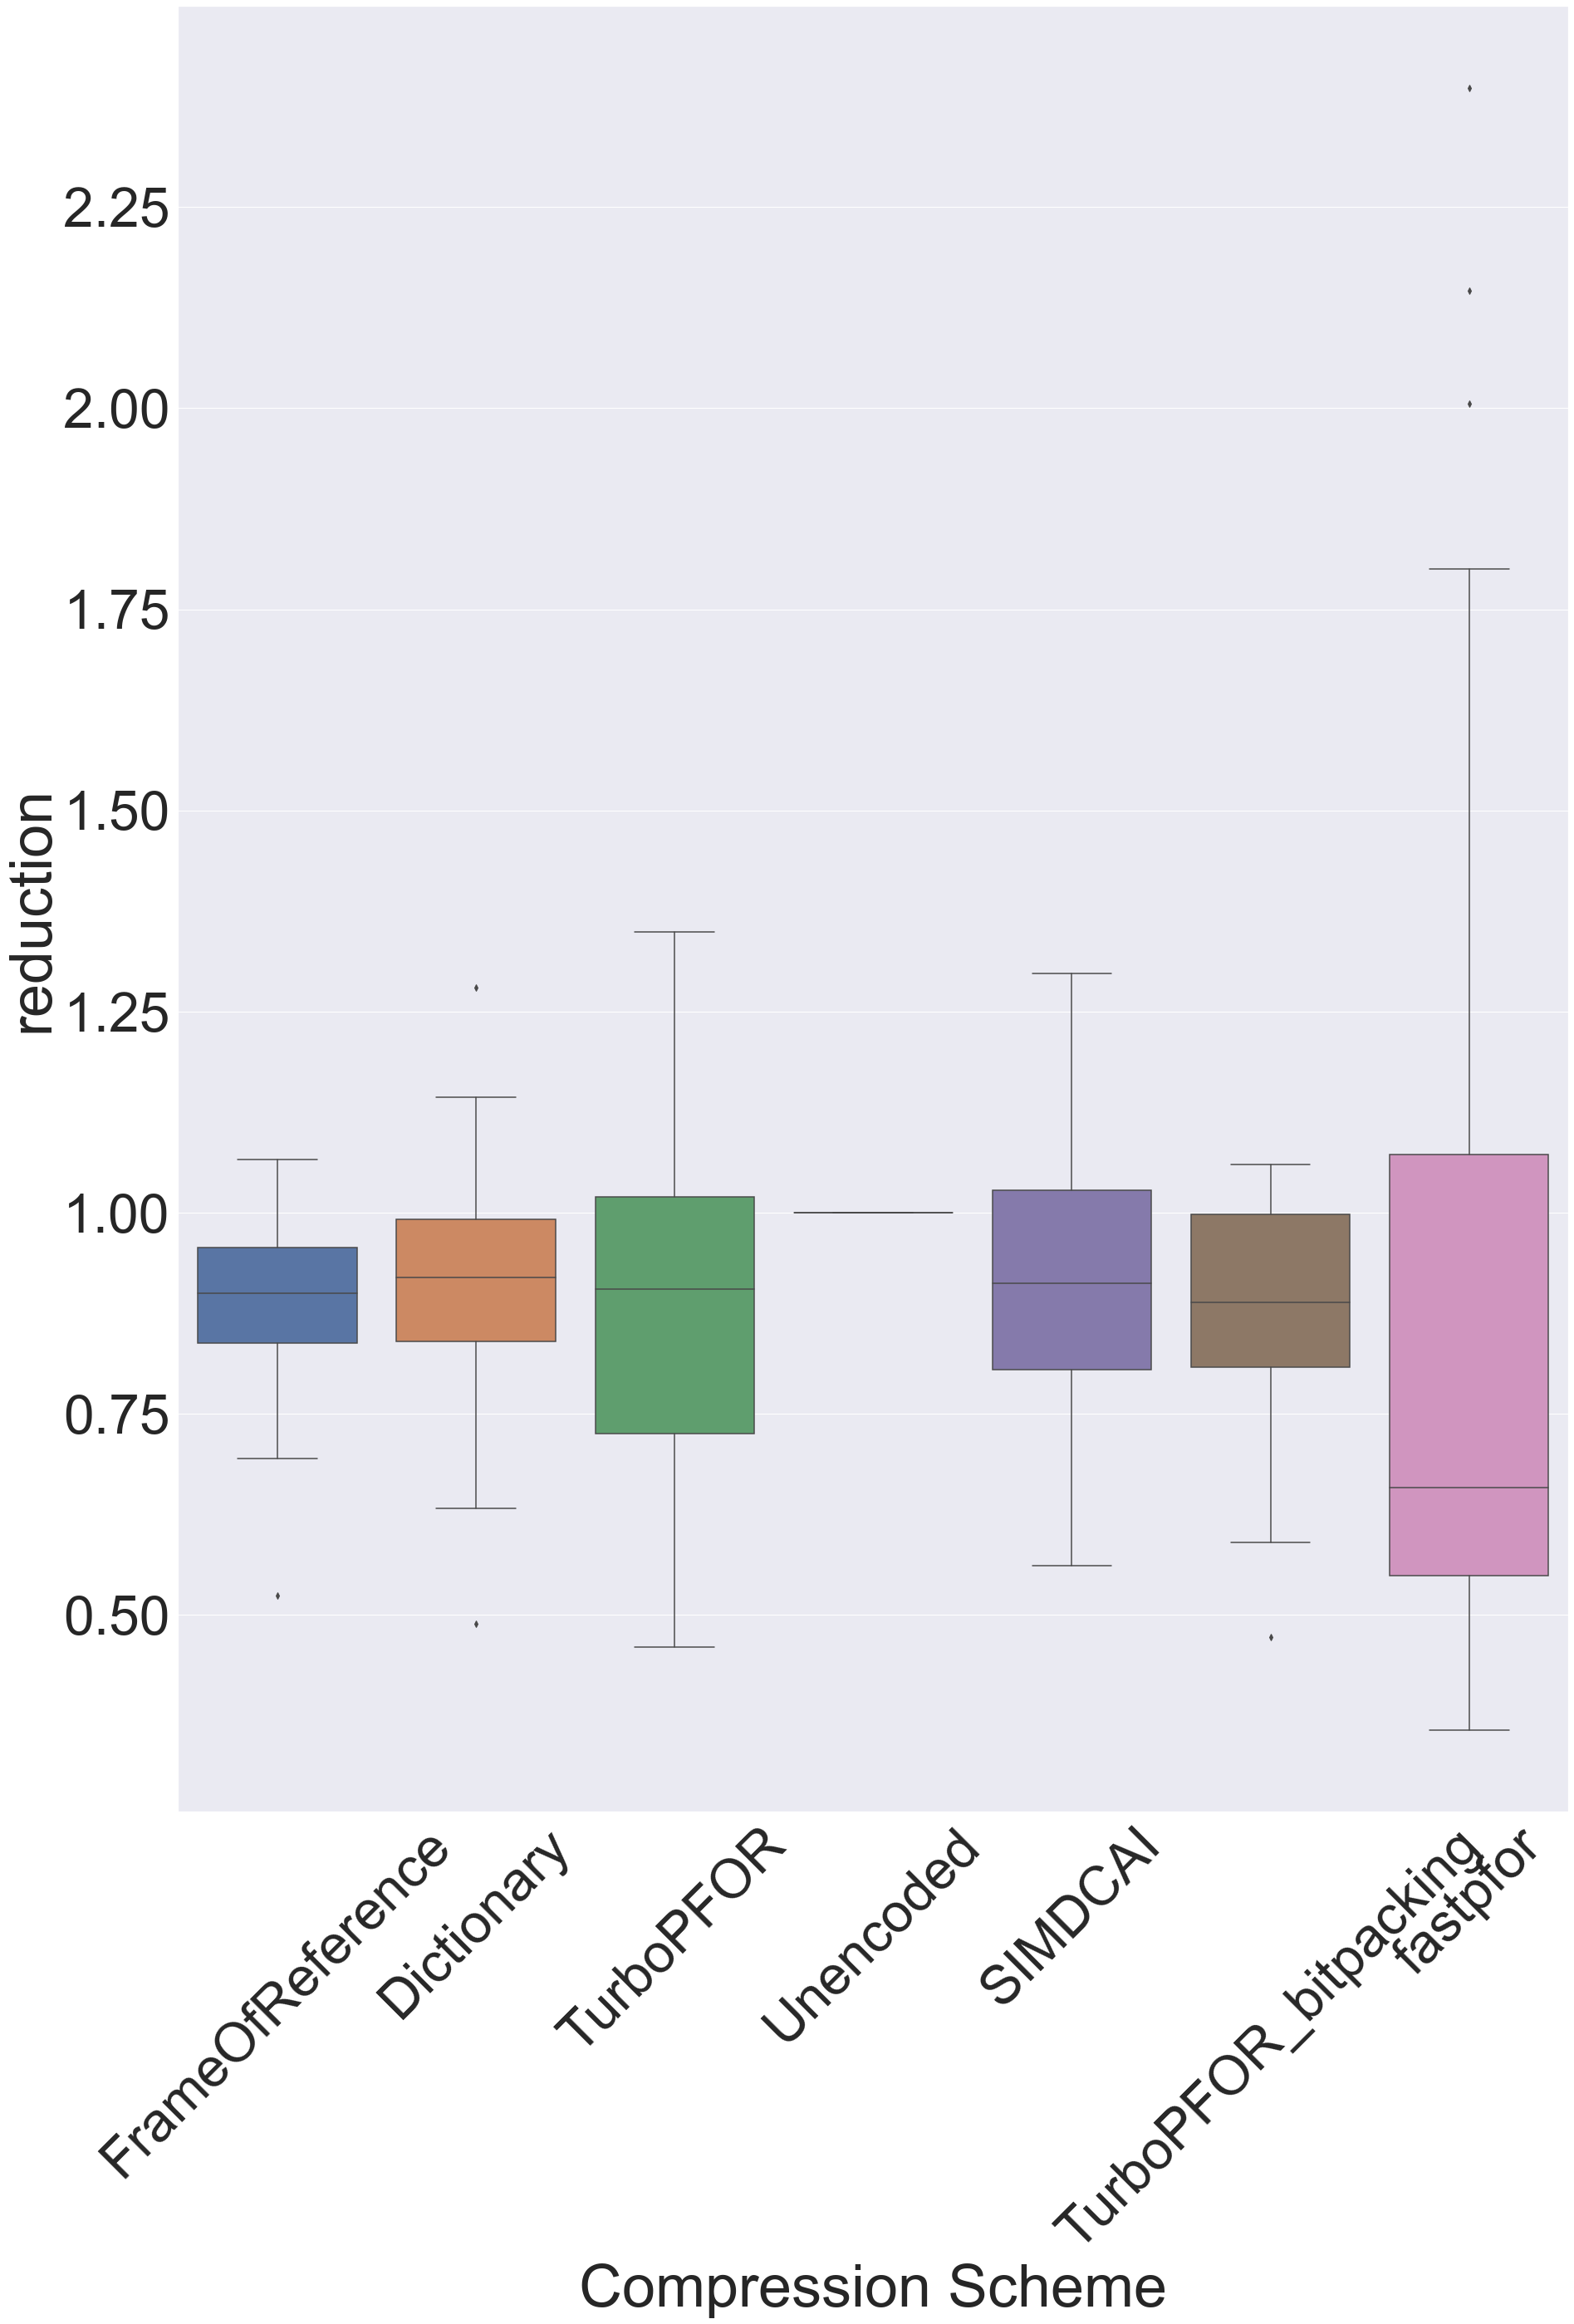

In [8]:
# Relative Difference
def with_relative_duration(data: DataFrame) -> DataFrame:
    dictionary_results: DataFrame = data[data[LIBRARY_NAME] == "Unencoded"]
    columns_to_merge: List[str] = [QUERY_NAME, AVG_DURATION]
    with_baseline: DataFrame = data.merge(dictionary_results[columns_to_merge], on=[QUERY_NAME])
    with_baseline[RUNTIME_TO_BASELINE] = [encoded / baseline
                                             for encoded, baseline
                                             in zip(with_baseline[f"{AVG_DURATION}_x"], with_baseline[f"{AVG_DURATION}_y"])]
    return with_baseline

single_threaded_relative: DataFrame = with_relative_duration(low_level_single)
multi_threaded_relative: DataFrame = with_relative_duration(low_level_mult[low_level_mult[CLIENTS] == 28])
columns_to_merge: List[str] = [QUERY_NAME, LIBRARY_NAME, RUNTIME_TO_BASELINE]
combined: DataFrame = single_threaded_relative.merge(multi_threaded_relative[columns_to_merge], on=[LIBRARY_NAME, QUERY_NAME])
combined[REDUCTION] = [multi / single for single, multi
                         in zip(combined[f"{RUNTIME_TO_BASELINE}_x"],
                                combined[f"{RUNTIME_TO_BASELINE}_y"])]
sns.boxplot(data=combined, x=LIBRARY_NAME, y=REDUCTION)
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 [Text(0, 0, 'TPC-H 01'),
  Text(1, 0, 'TPC-H 02'),
  Text(2, 0, 'TPC-H 03'),
  Text(3, 0, 'TPC-H 04'),
  Text(4, 0, 'TPC-H 05'),
  Text(5, 0, 'TPC-H 06'),
  Text(6, 0, 'TPC-H 07'),
  Text(7, 0, 'TPC-H 08'),
  Text(8, 0, 'TPC-H 09'),
  Text(9, 0, 'TPC-H 10'),
  Text(10, 0, 'TPC-H 11'),
  Text(11, 0, 'TPC-H 12'),
  Text(12, 0, 'TPC-H 13'),
  Text(13, 0, 'TPC-H 14'),
  Text(14, 0, 'TPC-H 15'),
  Text(15, 0, 'TPC-H 16'),
  Text(16, 0, 'TPC-H 17'),
  Text(17, 0, 'TPC-H 18'),
  Text(18, 0, 'TPC-H 19'),
  Text(19, 0, 'TPC-H 20'),
  Text(20, 0, 'TPC-H 21'),
  Text(21, 0, 'TPC-H 22')])

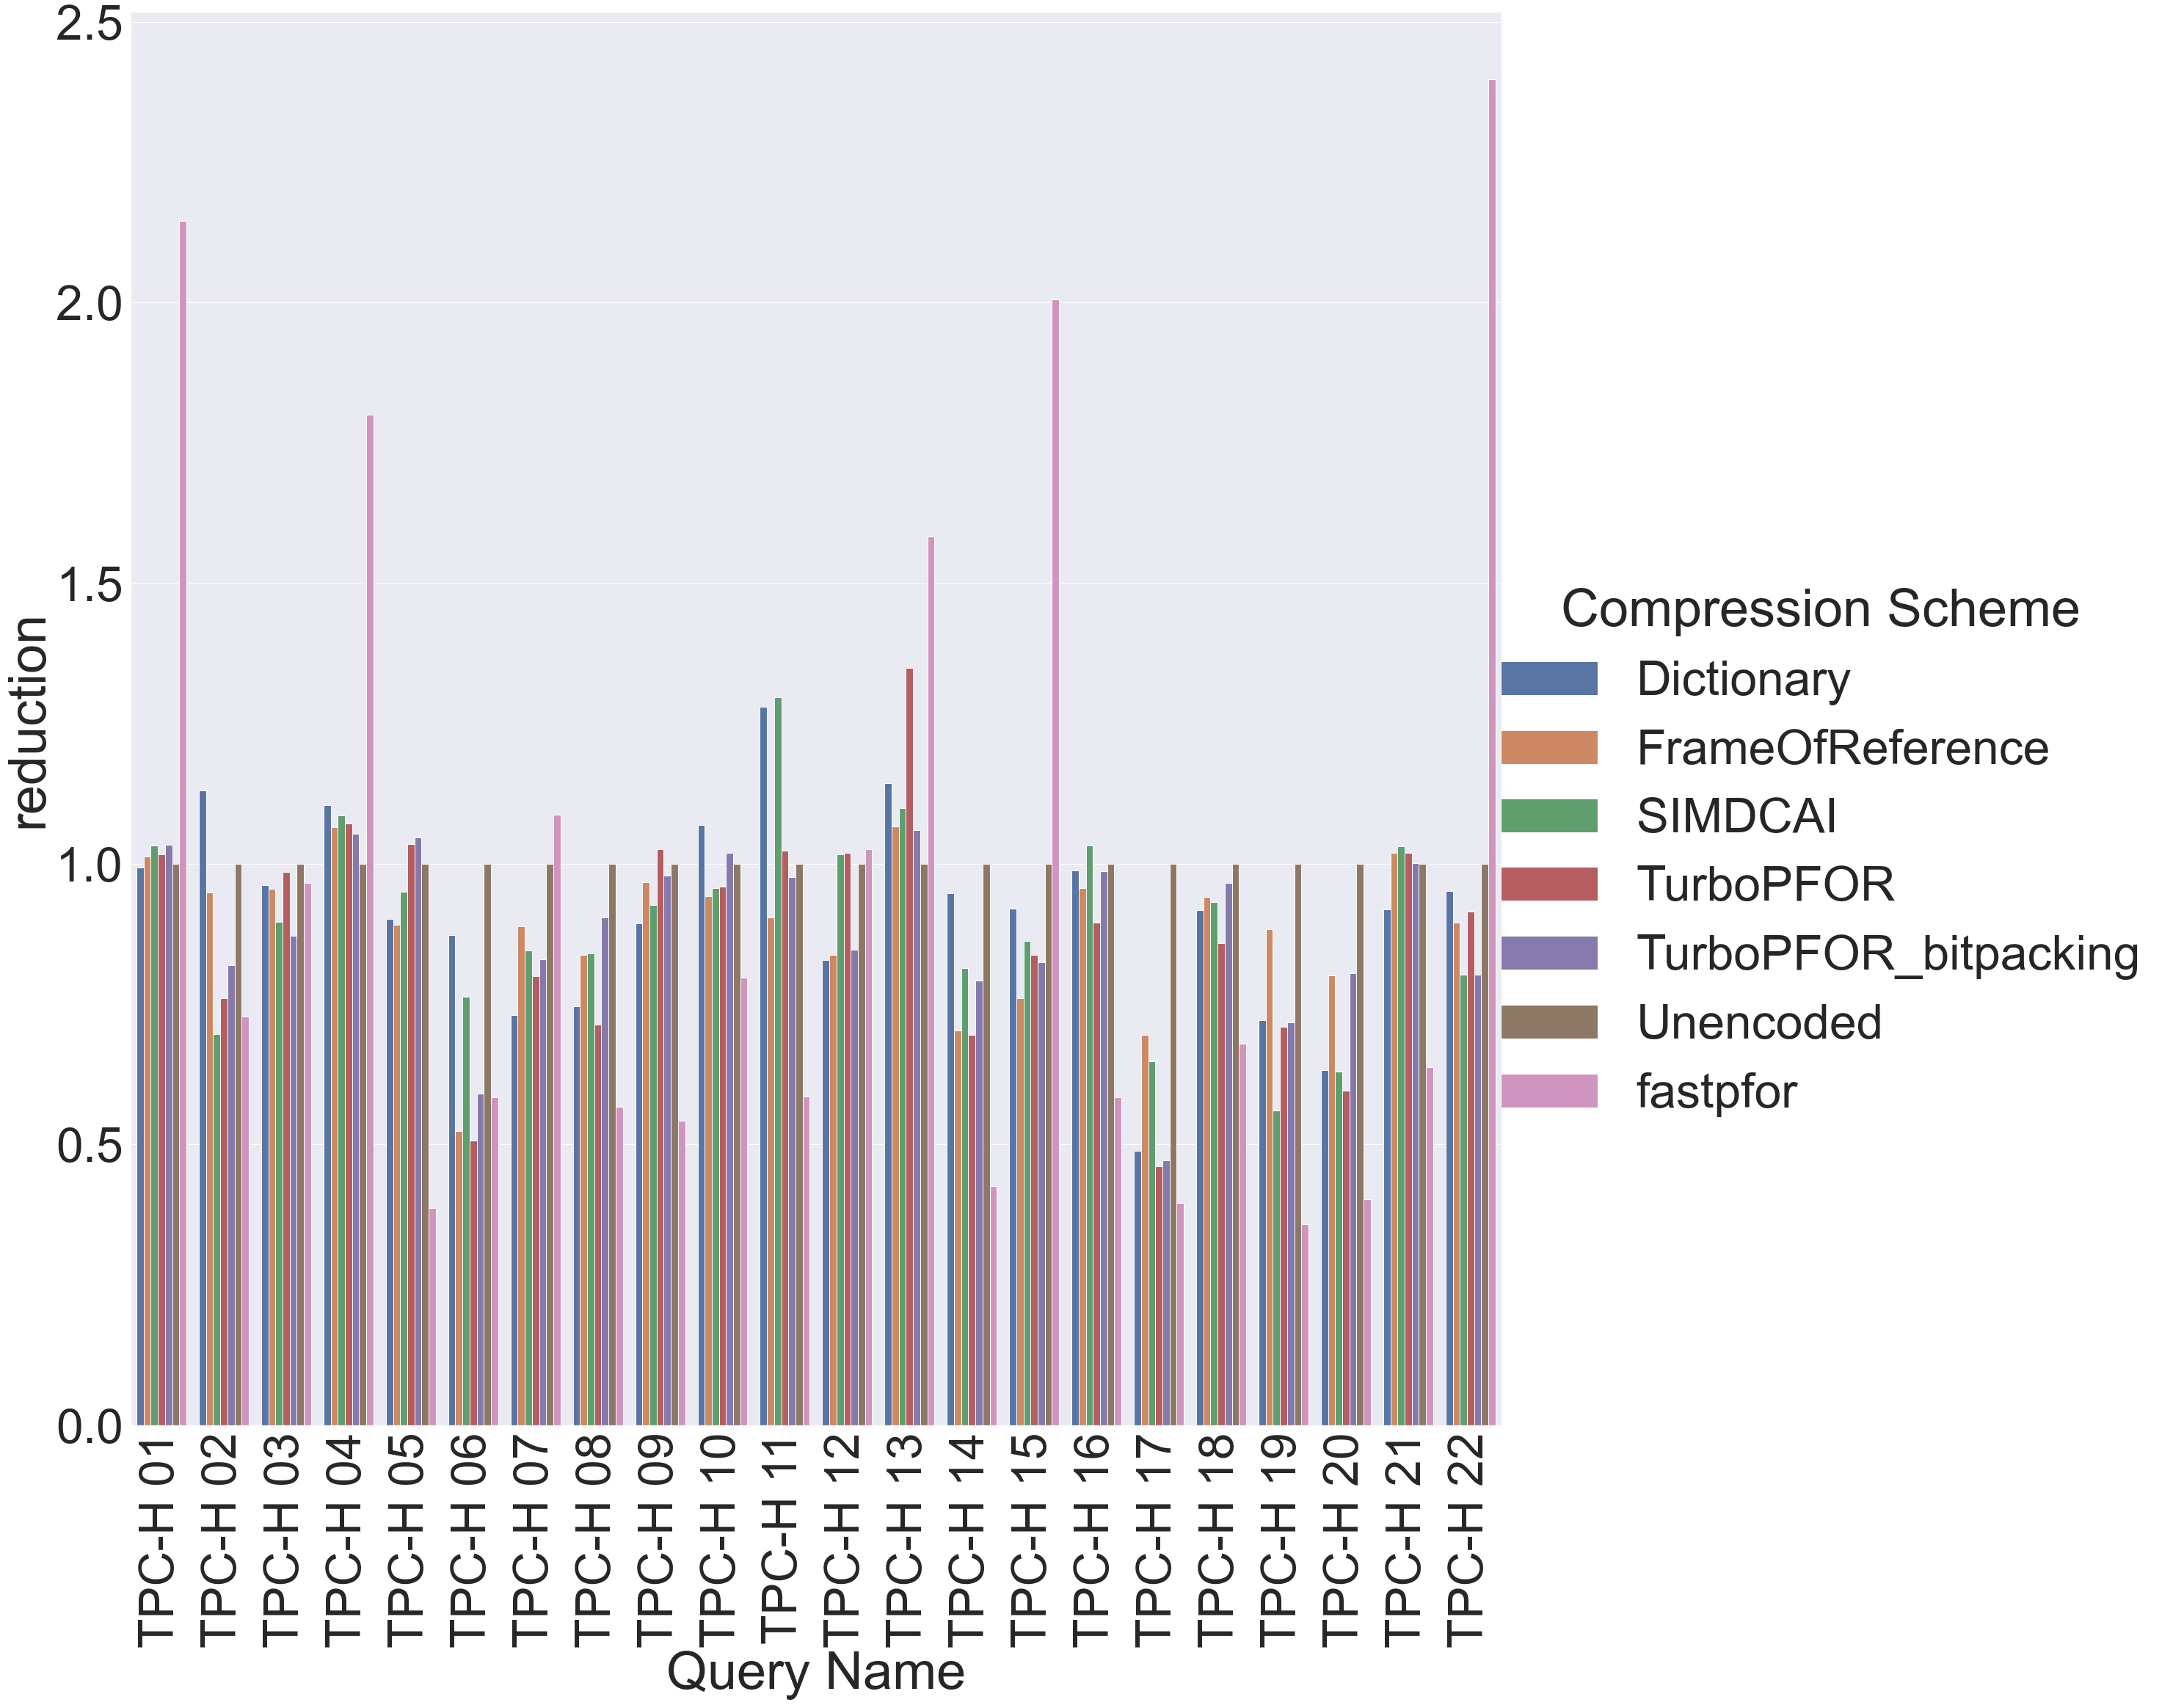

In [9]:
sns.catplot(data=combined, x=QUERY_NAME, y=REDUCTION, hue=LIBRARY_NAME, kind="bar", height=30, hue_order=hue_order)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Dictionary'),
  Text(1, 0, 'FrameOfReference'),
  Text(2, 0, 'SIMDCAI'),
  Text(3, 0, 'TurboPFOR'),
  Text(4, 0, 'TurboPFOR_bitpacking'),
  Text(5, 0, 'Unencoded'),
  Text(6, 0, 'fastpfor')])

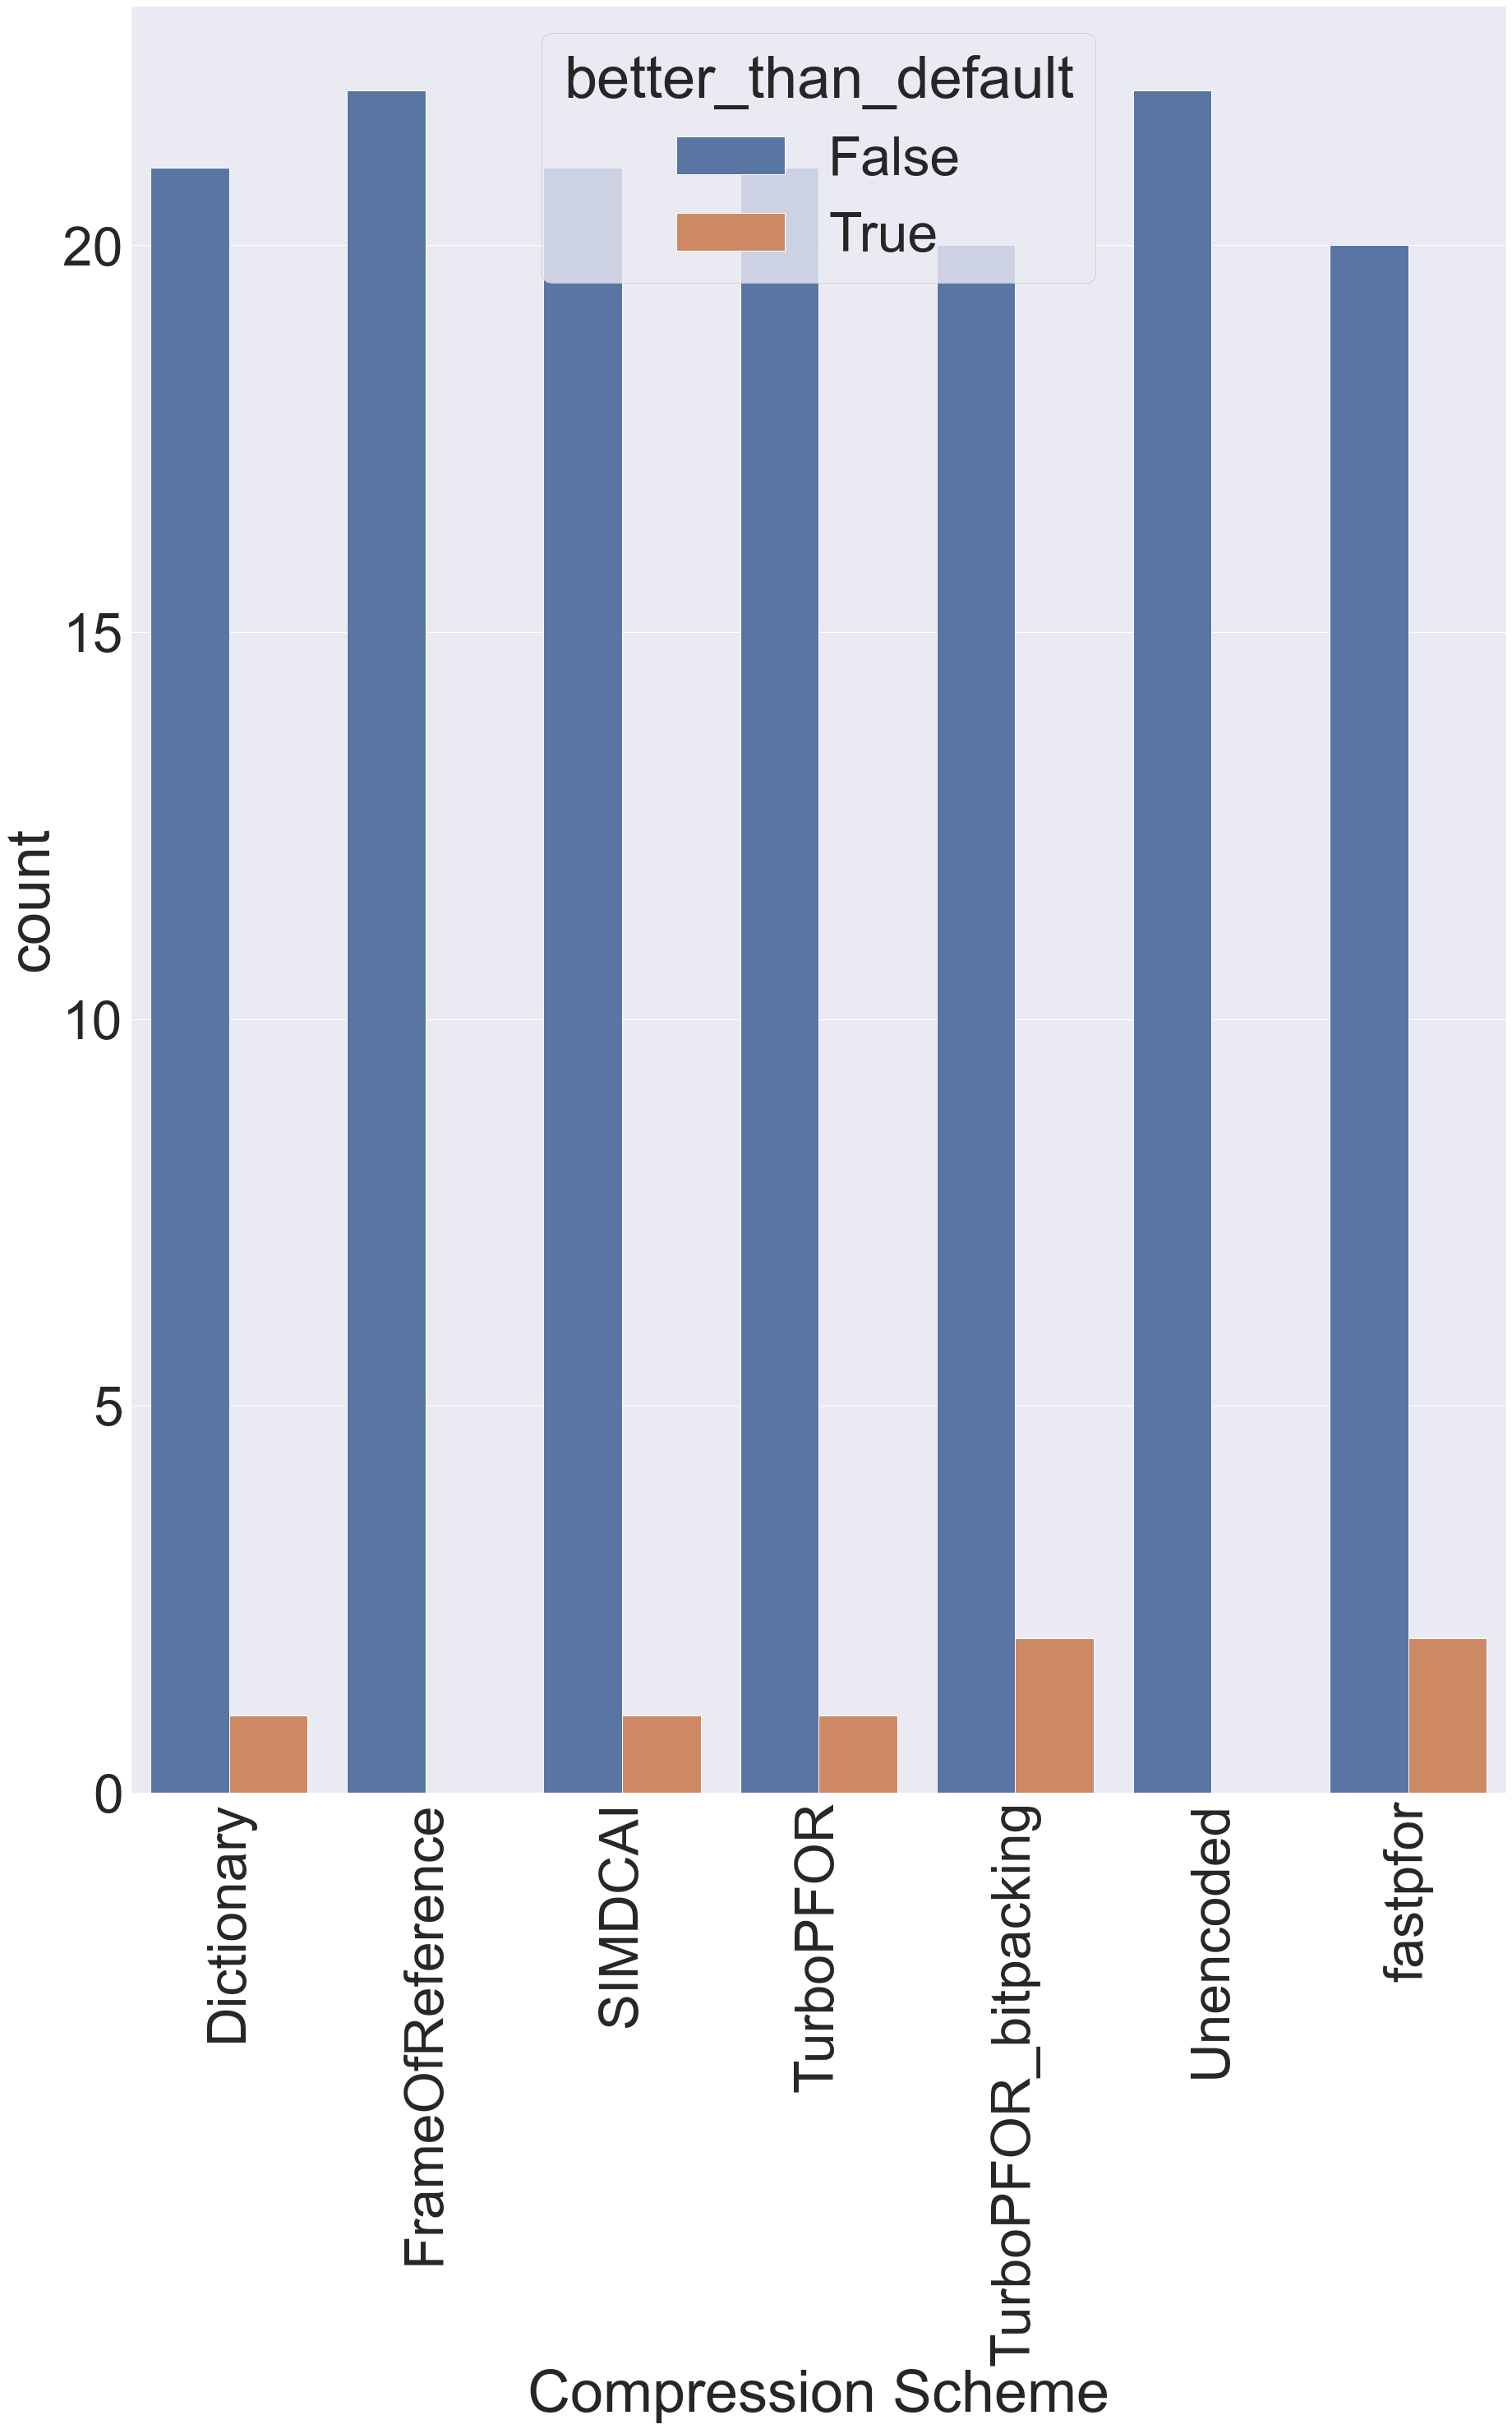

In [10]:
is_better_single: DataFrame = single_threaded_relative.copy()
is_better_multi: DataFrame = multi_threaded_relative.copy()
is_better_single[BETTER_THAN_DEFAULT] = [rel_runtime < 1 for rel_runtime in is_better_single[RUNTIME_TO_BASELINE]]
is_better_multi[BETTER_THAN_DEFAULT] = [rel_runtime < 1 for rel_runtime in is_better_multi[RUNTIME_TO_BASELINE]]
order: List[str] = sorted(single_threaded_relative[LIBRARY_NAME].drop_duplicates())
sns.countplot(data=is_better_single, x=LIBRARY_NAME, hue=BETTER_THAN_DEFAULT, order=order)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Dictionary'),
  Text(1, 0, 'FrameOfReference'),
  Text(2, 0, 'SIMDCAI'),
  Text(3, 0, 'TurboPFOR'),
  Text(4, 0, 'TurboPFOR_bitpacking'),
  Text(5, 0, 'Unencoded'),
  Text(6, 0, 'fastpfor')])

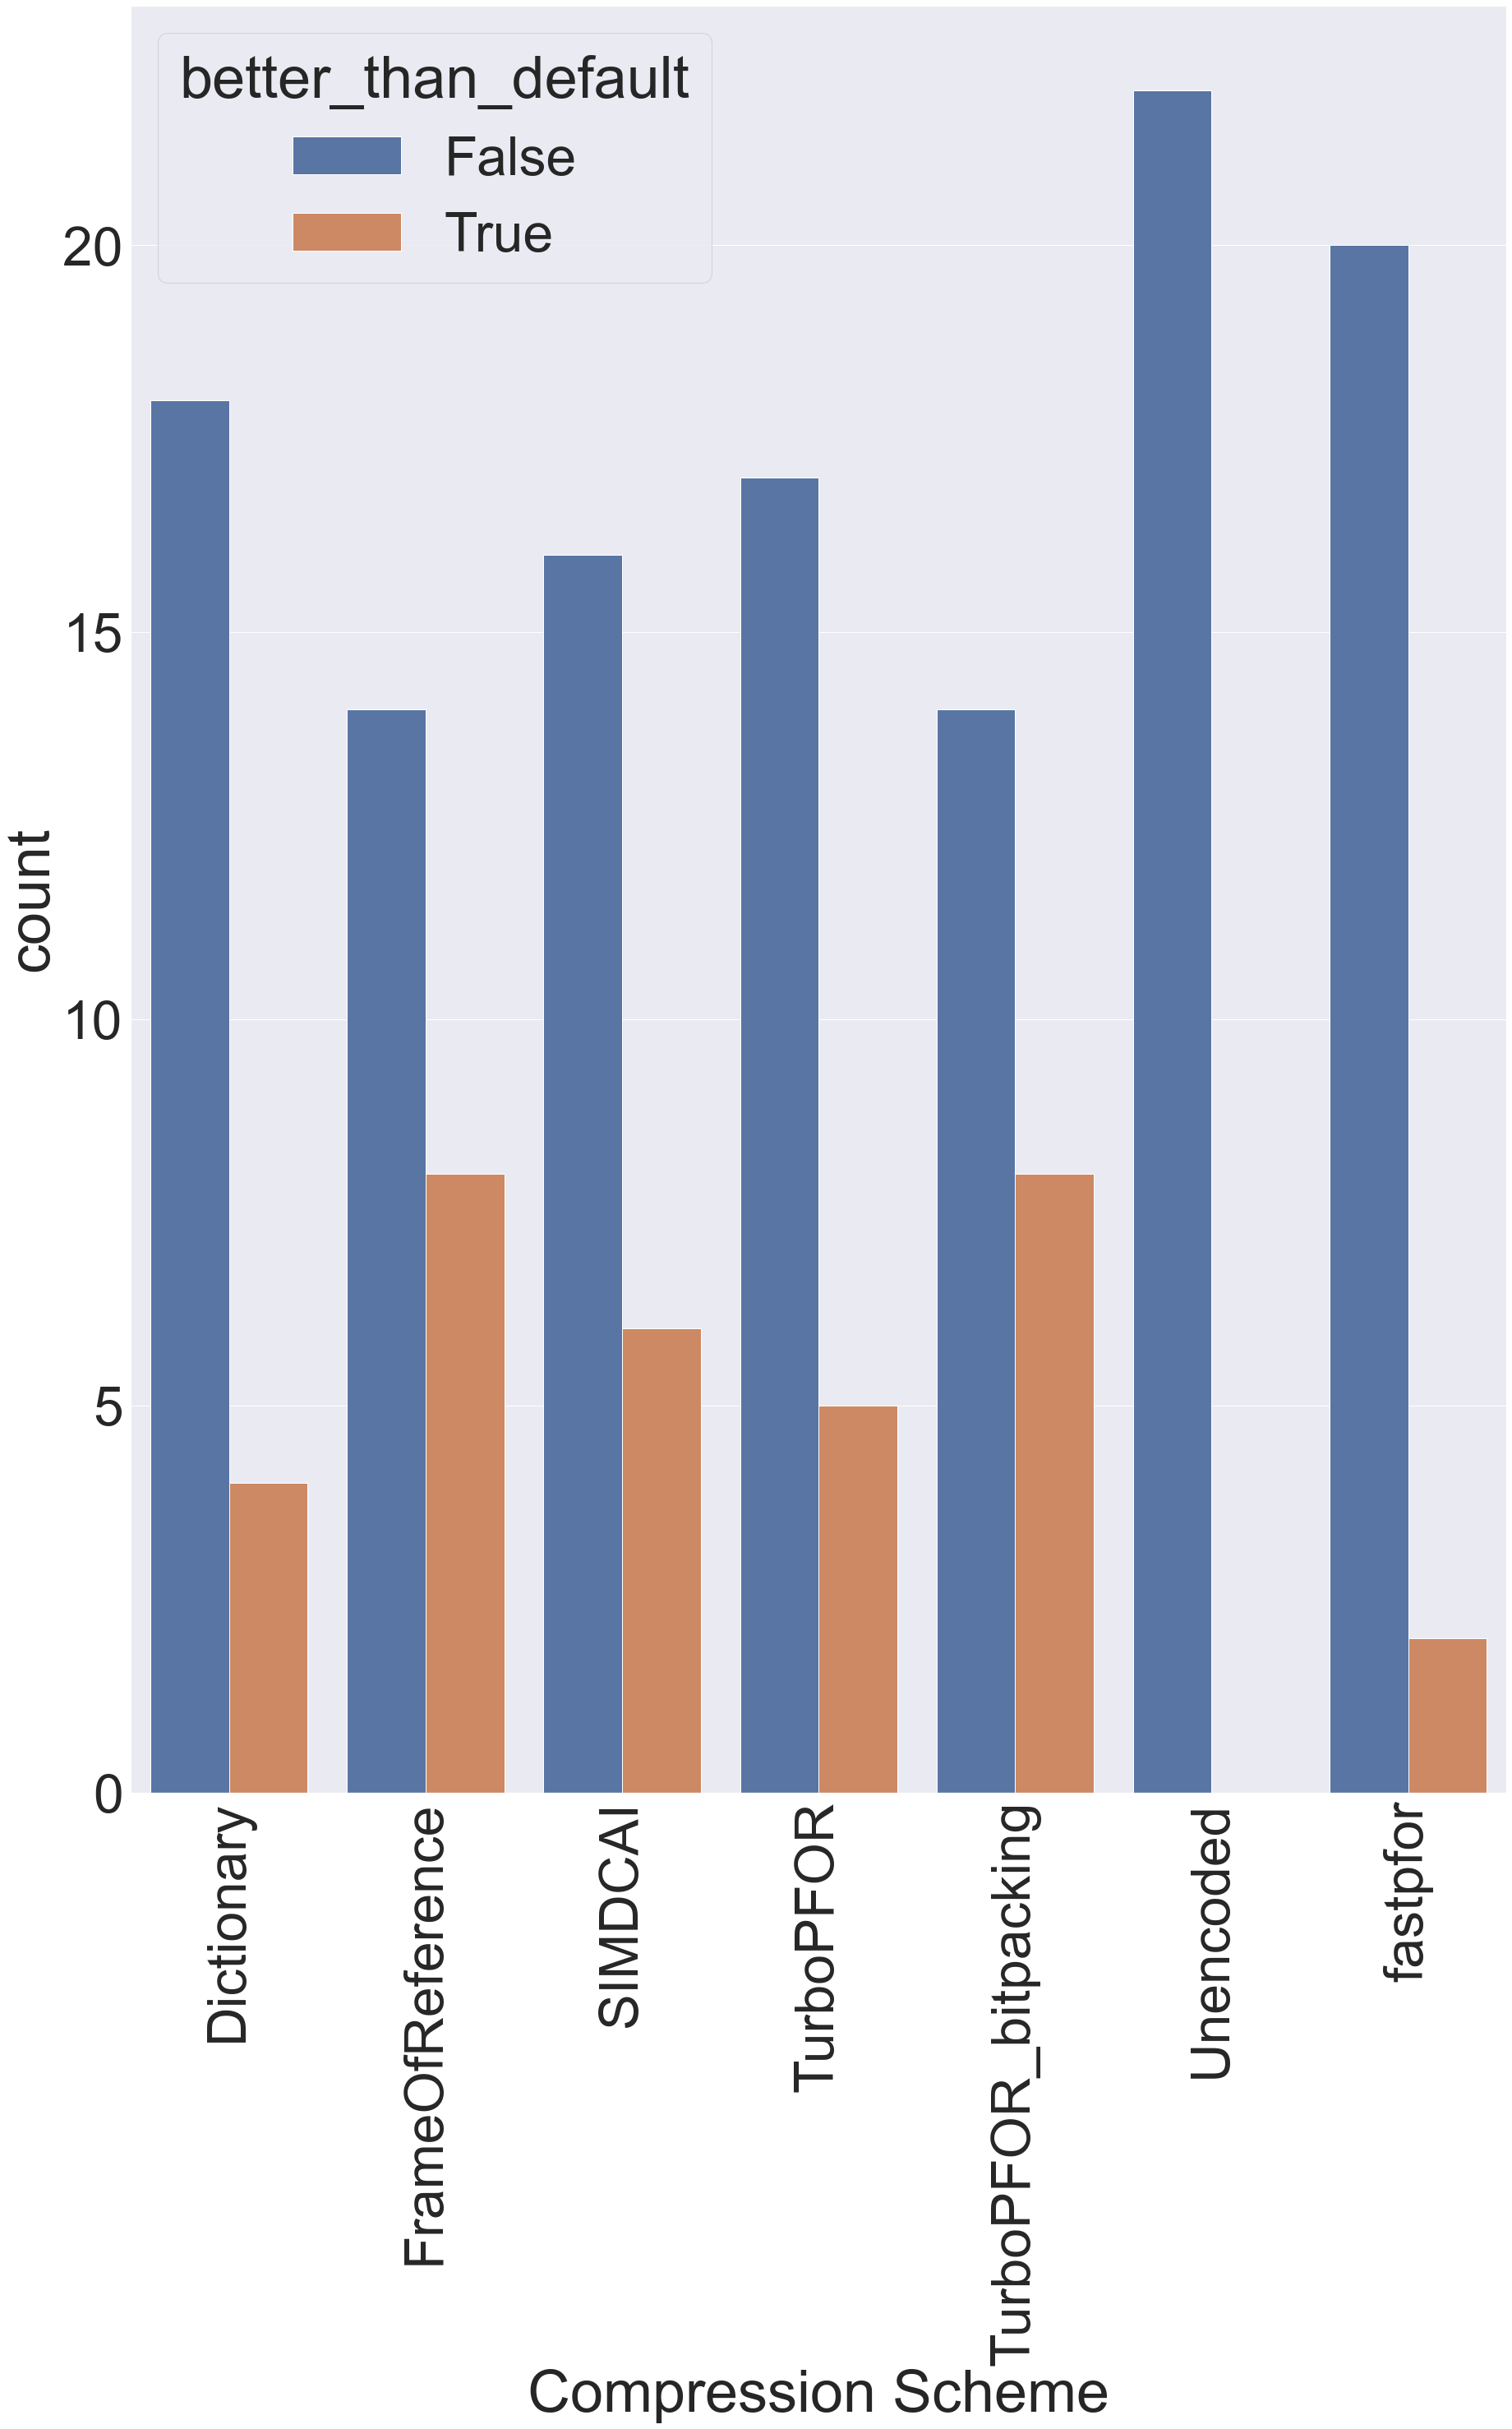

In [11]:
sns.countplot(data=is_better_multi, x=LIBRARY_NAME, hue=BETTER_THAN_DEFAULT, order=order)
plt.xticks(rotation=90)

In [12]:
integer_compressed: DataFrame = load_sizes(sizes_folder / "sizes_fastpfor.txt")
dictionary: DataFrame = load_sizes(sizes_folder / "sizes_Dictionary.txt")
columns_to_merge: List[str] = ["table_name", "chunk_id", "column_id", "size_in_bytes"]
merged: DataFrame = integer_compressed.merge(dictionary[columns_to_merge], on=["table_name", "chunk_id", "column_id"])
merged

,table_name,chunk_id,column_id,column_name,column_data_type,distinct_value_count,encoding_type,vector_compression_type,size_in_bytes_x,point_accesses,sequential_accesses,monotonic_accesses,random_accesses,dictionary_accesses,size_in_bytes_y
0,nation,0,0,n_nationkey,int,25,FastPFOR,NULL,173,30,375,460,88,0,221
1,nation,0,1,n_name,string,25,Dictionary,FixedSize1ByteAligned,1153,0,1325,0,9057583,3428417,1153
2,nation,0,2,n_regionkey,int,5,FastPFOR,NULL,173,0,1625,0,0,0,141
3,nation,0,3,n_comment,string,25,Dictionary,FixedSize1ByteAligned,3035,0,25,0,0,25,3035
4,part,0,0,p_partkey,int,65535,FastPFOR,NULL,133397,0,12648255,47971,65487,0,393306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17811,customer,22,6,c_mktsegment,string,5,Dictionary,FixedSize1ByteAligned,58558,0,116460,0,0,58235,58558
17812,customer,22,7,c_comment,string,58226,Dictionary,FixedSize2ByteAligned,6711930,0,58230,0,14803,58230,6711930
17813,region,0,0,r_regionkey,int,5,FastPFOR,NULL,153,62,15,0,0,0,121
17814,region,0,1,r_name,string,5,Dictionary,FixedSize1ByteAligned,333,0,315,0,0,315,333


In [13]:
# Get DB Columns where Int Compression Had the most impact
sizes_per_column = merged.groupby(["table_name", "column_name", "column_data_type"], as_index=False)["size_in_bytes_x", "size_in_bytes_y"].sum()
sizes_per_column["compression"] = [x / y
                                     for x, y in zip(sizes_per_column["size_in_bytes_x"],
                                                     sizes_per_column["size_in_bytes_y"])]
only_int_columns = sizes_per_column[sizes_per_column["column_data_type"] == "int"]
only_int_columns

<ipython-input-13-a53c358f066a>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sizes_per_column = merged.groupby(["table_name", "column_name", "column_data_type"], as_index=False)["size_in_bytes_x", "size_in_bytes_y"].sum()


,table_name,column_name,column_data_type,size_in_bytes_x,size_in_bytes_y,compression
3,customer,c_custkey,int,3735507,9002208,0.414955
6,customer,c_nationkey,int,988919,1504508,0.657304
12,lineitem,l_linenumber,int,24579408,60099636,0.408978
14,lineitem,l_orderkey,int,197047804,349234404,0.564228
15,lineitem,l_partkey,int,159518292,356116088,0.447939
22,lineitem,l_suppkey,int,129565372,296077600,0.437606
26,nation,n_nationkey,int,173,221,0.782805
27,nation,n_regionkey,int,173,141,1.226950
30,orders,o_custkey,int,39888737,88066192,0.452940
32,orders,o_orderkey,int,49273293,90021984,0.547347


In [14]:
dictionary.groupby(["column_data_type"], as_index=False)["size_in_bytes"].sum()

,column_data_type,size_in_bytes
0,float,676386560
1,int,1372782099
2,string,7950670887


In [15]:
high_level_mult

,benchmark_run_name,Total Runtime (in seconds),avg_throughput,Compression Scheme,with_lto,clients,multithreaded,float,int,string
0,./tpch_Dictionary_14_shuffled.json,41.228798,0.336834,Dictionary,False,14,True,676386560.0,1.372782e+09,7.950671e+09
1,./tpch_Dictionary_28_shuffled.json,60.205721,0.460573,Dictionary,False,28,True,676386560.0,1.372782e+09,7.950671e+09
2,./tpch_FrameOfReference_14_shuffled.json,38.446318,0.356780,FrameOfReference,False,14,True,676386560.0,9.912806e+08,7.950671e+09
3,./tpch_FrameOfReference_28_shuffled.json,55.875643,0.490804,FrameOfReference,False,28,True,676386560.0,9.912806e+08,7.950671e+09
4,./tpch_SIMDCAI_14_shuffled.json,39.593418,0.346463,SIMDCAI,False,14,True,676386560.0,6.464946e+08,7.950671e+09
5,./tpch_SIMDCAI_28_shuffled.json,58.858771,0.465884,SIMDCAI,False,28,True,676386560.0,6.464946e+08,7.950671e+09
6,./tpch_TurboPFOR_14_shuffled.json,41.378711,0.331666,TurboPFOR,False,14,True,676386560.0,6.514422e+08,7.950671e+09
7,./tpch_TurboPFOR_28_shuffled.json,60.672550,0.452128,TurboPFOR,False,28,True,676386560.0,6.514422e+08,7.950671e+09
8,./tpch_TurboPFOR_bitpacking_14_shuffled.json,38.599272,0.355270,TurboPFOR_bitpacking,False,14,True,676386560.0,6.557167e+08,7.950671e+09
9,./tpch_TurboPFOR_bitpacking_28_shuffled.json,56.325642,0.486986,TurboPFOR_bitpacking,False,28,True,676386560.0,6.557167e+08,7.950671e+09


In [16]:
high_level_single

,benchmark_run_name,Total Runtime (in seconds),avg_throughput,Compression Scheme,with_lto,clients,multithreaded,float,int,string
0,./tpch_Dictionary_singlethreaded.json,38.747185,1.537464,Dictionary,False,1,False,676386560.0,1.372782e+09,7.950671e+09
1,./tpch_FrameOfReference_singlethreaded.json,35.447879,1.673023,FrameOfReference,False,1,False,676386560.0,9.912806e+08,7.950671e+09
2,./tpch_SIMDCAI_singlethreaded.json,36.831127,1.531125,SIMDCAI,False,1,False,676386560.0,6.464946e+08,7.950671e+09
3,./tpch_TurboPFOR_bitpacking_singlethreaded.json,35.077938,1.606486,TurboPFOR_bitpacking,False,1,False,676386560.0,6.557167e+08,7.950671e+09
4,./tpch_TurboPFOR_singlethreaded.json,37.203742,1.531067,TurboPFOR,False,1,False,676386560.0,6.514422e+08,7.950671e+09
5,./tpch_Unencoded_singlethreaded.json,33.565790,1.883015,Unencoded,False,1,False,676386560.0,1.266756e+09,7.950671e+09
6,./tpch_fastpfor_singlethreaded.json,2833.905662,0.073615,fastpfor,False,1,False,676386560.0,6.638252e+08,7.950671e+09
